## Preprocessing Events Data (.csv)

Note: ChatGPT was used for debugging and aiding in visualization as suggested by the tutors of the course

In [1]:
# Import all packages required
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# Read events data into a pandas data frame
events_df = pd.read_csv("../data/raw/nyc_events_raw.csv")

In [3]:
# Distribution of data
events_df.count()

Event ID               4841354
Event Name             4841354
Start Date/Time        4841354
End Date/Time          4841354
Event Agency           4841354
Event Type             4841354
Event Borough          4841354
Event Location         4841354
Event Street Side       140845
Street Closure Type     144866
Community Board        4841354
Police Precinct        4841354
dtype: int64

### Drop all duplicate rows (same values across all columns)

In [4]:
events_df = events_df.drop_duplicates()

In [5]:
events_df.count()

Event ID               272767
Event Name             272767
Start Date/Time        272767
End Date/Time          272767
Event Agency           272767
Event Type             272767
Event Borough          272767
Event Location         272767
Event Street Side       11265
Street Closure Type     11533
Community Board        272767
Police Precinct        272767
dtype: int64

In [6]:
# Rename columns for ease
rename_columns = {
    'Event ID': 'event_id',
    'Event Name': 'event_name',
    'Start Date/Time': 'start_date_time',
    'End Date/Time': 'end_date_time',
    'Event Agency': 'event_agency',
    'Event Type': 'event_type',
    'Event Borough': 'event_borough',
    'Event Location': 'event_location',
    'Event Street Side': 'event_street_side',
    'Street Closure Type': 'street_closure_type',
    'Community Board': 'community_board',
    'Police Precinct': 'police_precinct' 
}

events_df.rename(columns=rename_columns, inplace=True)

In [7]:
# Further remove any events where the event id and start time are the same
events_df = events_df.drop_duplicates(subset=['event_id','start_date_time'])

In [8]:
events_df.count()

event_id               265933
event_name             265933
start_date_time        265933
end_date_time          265933
event_agency           265933
event_type             265933
event_borough          265933
event_location         265933
event_street_side       11153
street_closure_type     11416
community_board        265933
police_precinct        265933
dtype: int64

### Remove events which are assumed to not be ideal in knowing demand for taxis

In [9]:
# Define keywords for unwanted events
unwanted_keywords = ["closure", "maintenance", "parking", "covid", "clean", "construction", "vaccine", "vaccination"]

# Filter out unwanted events using a case-insensitive check
pattern = '|'.join(unwanted_keywords)
events_df = events_df[~events_df['event_name'].str.contains(pattern, case=False, na=False)]

In [10]:
events_df.count()

event_id               255525
event_name             255525
start_date_time        255525
end_date_time          255525
event_agency           255525
event_type             255525
event_borough          255525
event_location         255525
event_street_side       10888
street_closure_type     11151
community_board        255525
police_precinct        255525
dtype: int64

In [11]:
# Drop the specified columns which don't tell us much about events
columns_to_drop = ['event_agency', 'street_closure_type', 'community_board', 'event_street_side']
events_df = events_df.drop(columns=columns_to_drop)

In [12]:
# Standardize date and time format
events_df['start_date_time'] = pd.to_datetime(events_df['start_date_time'], format='%m/%d/%Y %I:%M:%S %p')
events_df['end_date_time'] = pd.to_datetime(events_df['end_date_time'], format='%m/%d/%Y %I:%M:%S %p')

# Extract relevant time features
events_df['event_date'] = events_df['start_date_time'].dt.date
events_df['start_hour'] = events_df['start_date_time'].dt.hour
events_df['end_hour'] = events_df['end_date_time'].dt.hour
events_df['day_of_week'] = events_df['start_date_time'].dt.dayofweek


In [13]:
# For events where there are multiple precincts, split it into multiple rows
events_df['police_precinct'] = events_df['police_precinct'].str.split(',')
events_df = events_df.explode('police_precinct')

# Remove rows where 'police_precinct' is empty (empty string)
events_df = events_df[events_df['police_precinct'].str.strip() != '']

In [14]:
events_df.count()

event_id           288692
event_name         288692
start_date_time    288692
end_date_time      288692
event_type         288692
event_borough      288692
event_location     288692
police_precinct    288692
event_date         288692
start_hour         288692
end_hour           288692
day_of_week        288692
dtype: int64

In [15]:
events_df.head()

,event_id,event_name,start_date_time,end_date_time,event_type,event_borough,event_location,police_precinct,event_date,start_hour,end_hour,day_of_week
1,674138,Catholic League Creche Display 2022,2023-01-01,2023-01-01 23:59:00,Special Event,Manhattan,Central Park: Grand Army Plaza - Pulitzer Foun...,18,2023-01-01,0,23,6
6,673846,Big Apple Circus,2023-01-01,2023-01-01 23:59:00,Special Event,Manhattan,"Damrosch Park: Bandshell ,Damrosch Park: Tent ...",20,2023-01-01,0,23,6
14,619636,Pulitzer Fountain Holiday Lights Display,2023-01-01,2023-01-01 23:59:00,Special Event,Manhattan,Central Park: Grand Army Plaza - Pulitzer Foun...,18,2023-01-01,0,23,6
17,679004,Bowling Green Christmas Tree,2023-01-01,2023-01-01 23:59:00,Special Event,Manhattan,Bowling Green: Charging Bull Triangle,1,2023-01-01,0,23,6
18,673842,Big Apple Circus,2023-01-01,2023-01-01 23:59:00,Special Event,Manhattan,"Damrosch Park: Damrosch Park ,Damrosch Park: S...",20,2023-01-01,0,23,6


### Keeping events under valid precincts
Although the precinct numbers range from 1 to 123, there are only 77 of them

This knowledge was taken from https://www.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page

In [16]:
# Read in the list of precincts
precinct_shape = pd.read_csv("../data/raw/precincts/nypp.csv")
valid_precincts = precinct_shape['Precinct'].dropna().unique()

# Convert both to the same data type (e.g., int)
events_df['police_precinct'] = events_df['police_precinct'].astype(int)
valid_precincts = valid_precincts.astype(int)

# filter the data frame to only keep the valid precincts
events_df = events_df[events_df['police_precinct'].isin(valid_precincts)]

In [17]:
events_df.count()

event_id           288411
event_name         288411
start_date_time    288411
end_date_time      288411
event_type         288411
event_borough      288411
event_location     288411
police_precinct    288411
event_date         288411
start_hour         288411
end_hour           288411
day_of_week        288411
dtype: int64

## Create a mapping of the precinct number to the borough

In [18]:
# Extract unique pairs of police precinct and event borough
precinct_borough_df = events_df[['police_precinct', 'event_borough']].drop_duplicates()

# Save this DataFrame to a CSV file
precinct_borough_df.to_csv('../data/curated/precinct_to_borough_mapping.csv', index=False)

# Results
precinct_borough_df.head()

,police_precinct,event_borough
1,18,Manhattan
6,20,Manhattan
17,1,Manhattan
19,13,Manhattan
19,17,Manhattan


In [19]:
events_df.count()

event_id           288411
event_name         288411
start_date_time    288411
end_date_time      288411
event_type         288411
event_borough      288411
event_location     288411
police_precinct    288411
event_date         288411
start_hour         288411
end_hour           288411
day_of_week        288411
dtype: int64

## Calculate the daily number of events per borough

In [20]:
# First, drop duplicate rows that have the same event_id, event_date, and event_borough
unique_events_per_borough = events_df.drop_duplicates(subset=['event_id', 'event_date', 'event_borough'])

# Now, calculate daily counts of unique events per borough
daily_counts_per_borough = unique_events_per_borough.groupby(['event_date', 'event_borough']).size().unstack(fill_value=0)

daily_counts_per_borough

event_borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
event_date,,,,,
2023-01-01,10,74,71,37,14
2023-01-02,14,30,47,18,12
2023-01-03,13,35,41,18,14
2023-01-04,11,31,40,23,11
2023-01-05,12,31,47,20,12
...,...,...,...,...,...
2024-04-26,0,3,16,1,0
2024-04-27,0,9,21,7,0
2024-04-28,0,6,16,5,0


## Calculate the number of events starting per hour

In [21]:
# Drop duplicates to ensure each event is counted only once per date and hour
unique_events_per_hour = events_df.drop_duplicates(subset=['event_id', 'event_date', 'start_hour'])

# Aggregate: Total event count by date and hour
event_count_by_date_hour = unique_events_per_hour.groupby(['event_date', 'start_hour']).size().reset_index(name='total_event_count')

# Show the result
event_count_by_date_hour


,event_date,start_hour,total_event_count
0,2023-01-01,0,8
1,2023-01-01,6,2
2,2023-01-01,7,9
3,2023-01-01,8,36
4,2023-01-01,9,36
...,...,...,...
7175,2024-04-29,15,1
7176,2024-04-30,0,1
7177,2024-04-30,6,1
7178,2024-04-30,13,1


## Calculate the count of events starting per day

In [22]:
# Drop duplicates to ensure each event is counted only once per date
unique_events_per_date = events_df.drop_duplicates(subset=['event_id', 'event_date'])

# Aggregate: Total event count by date
event_count_by_date = unique_events_per_date.groupby('event_date').size().reset_index(name='total_event_count')

# Show the result
event_count_by_date


,event_date,total_event_count
0,2023-01-01,206
1,2023-01-02,121
2,2023-01-03,121
3,2023-01-04,116
4,2023-01-05,122
...,...,...
465,2024-04-26,20
466,2024-04-27,37
467,2024-04-28,27
468,2024-04-29,3


## Total number of events starting per hour

In [23]:
# Drop duplicates to ensure each event is counted only once per hour
unique_events_per_hour_only = events_df.drop_duplicates(subset=['event_id', 'start_hour'])

# Aggregate: Total event count by hour
event_count_by_hour = unique_events_per_hour_only.groupby('start_hour').size().reset_index(name='total_event_count')

# Show the result
event_count_by_hour


,start_hour,total_event_count
0,0,547
1,1,26
2,2,9
3,3,4
4,4,21
5,5,61
6,6,257
7,7,530
8,8,3795
9,9,4608


In [24]:
# Define the directory path for saving the event aggregates
output_dir = '../data/curated/events'

# Check if the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Cumulative number of events based on start and end time 
### To get the full view of number of events being run/held at a certain time

In [25]:
# Create a new DataFrame to hold the expanded event hours
expanded_events = []

for _, row in events_df.iterrows():
    for hour in range(row['start_hour'], row['end_hour'] + 1):
        expanded_events.append({
            'event_date': row['event_date'],
            'hour': hour,
            'event_id': row['event_id']
        })

expanded_events_df = pd.DataFrame(expanded_events)

# Drop duplicates to ensure each event is counted only once per date and hour
expanded_events_df_unique = expanded_events_df.drop_duplicates(subset=['event_id', 'event_date', 'hour'])

# Now aggregate to get the total event count for each date and hour
cumulative_event_count = expanded_events_df_unique.groupby(['event_date', 'hour']).size().reset_index(name='total_event_count')

# Show the cumulative result
cumulative_event_count.head(24)  # Show the first 24 rows

,event_date,hour,total_event_count
0,2023-01-01,0,8
1,2023-01-01,1,8
2,2023-01-01,2,8
3,2023-01-01,3,8
4,2023-01-01,4,8
5,2023-01-01,5,8
6,2023-01-01,6,10
7,2023-01-01,7,18
8,2023-01-01,8,54
9,2023-01-01,9,88


In [26]:
cumulative_event_count.to_csv("../data/curated/events/hourly_event_count.csv", index=False)

### Calculation of number of events per precinct

In [27]:
# Aggregate: Number of events per police precinct
events_per_precinct = events_df.groupby('police_precinct').size().reset_index(name='total_event_count')

# Show the result
events_per_precinct

,police_precinct,total_event_count
0,1,1148
1,5,6378
2,6,4185
3,7,4519
4,9,4328
...,...,...
72,115,2903
73,120,3822
74,121,54
75,122,6214


In [28]:
events_per_precinct.to_csv("../data/curated/events/event_per_precinct.csv", index=False)

### Similarly, calculation of events per borough

In [29]:
# First, drop duplicates to ensure each event is counted only once per borough
unique_events_per_borough = events_df.drop_duplicates(subset=['event_id', 'event_date', 'event_borough'])

# Then, aggregate the number of unique events per borough
events_per_borough = unique_events_per_borough.groupby('event_borough').size().reset_index(name='total_event_count')

# Show the result
events_per_borough

,event_borough,total_event_count
0,Bronx,35429
1,Brooklyn,64373
2,Manhattan,86497
3,Queens,55629
4,Staten Island,13243


In [30]:
events_per_borough.to_csv("../data/curated/events/event_per_borough.csv", index=False)

## Number of events hourly by precinct and boroughs

In [31]:
# Create a new DataFrame to hold the expanded event hours
expanded_events = []

for _, row in events_df.iterrows():
    for hour in range(row['start_hour'], row['end_hour'] + 1):
        expanded_events.append({
            'event_date': row['event_date'],
            'hour': hour,
            'police_precinct': row['police_precinct'],
            'event_borough': row['event_borough'],
            'event_id': row['event_id']
        })

expanded_events_df = pd.DataFrame(expanded_events)

# Drop duplicates to ensure each event is counted only once per precinct and hour
unique_events_per_precinct = expanded_events_df.drop_duplicates(subset=['event_id', 'event_date', 'hour', 'police_precinct'])

# Aggregate: Number of events per precinct and hour
hourly_events_per_precinct = unique_events_per_precinct.groupby(['event_date', 'hour', 'police_precinct']).size().reset_index(name='total_event_count')

# Drop duplicates to ensure each event is counted only once per borough and hour
unique_events_per_borough = expanded_events_df.drop_duplicates(subset=['event_id', 'event_date', 'hour', 'event_borough'])

# Aggregate: Number of events per borough and hour
hourly_events_per_borough = unique_events_per_borough.groupby(['event_date', 'hour', 'event_borough']).size().reset_index(name='total_event_count')

# Show the results
print(hourly_events_per_precinct.head(24))  # Show the first 24 rows for precincts
print(hourly_events_per_borough.head(24))   # Show the first 24 rows for boroughs


    event_date  hour  police_precinct  total_event_count
0   2023-01-01     0                1                  1
1   2023-01-01     0                5                  1
2   2023-01-01     0                7                  1
3   2023-01-01     0               13                  1
4   2023-01-01     0               17                  1
5   2023-01-01     0               18                  3
6   2023-01-01     0               20                  3
7   2023-01-01     1                1                  1
8   2023-01-01     1                5                  1
9   2023-01-01     1                7                  1
10  2023-01-01     1               13                  1
11  2023-01-01     1               17                  1
12  2023-01-01     1               18                  3
13  2023-01-01     1               20                  3
14  2023-01-01     2                1                  1
15  2023-01-01     2                5                  1
16  2023-01-01     2           

In [32]:
hourly_events_per_precinct.to_csv("../data/curated/events/hourly_event_per_precinct.csv", index=False)
hourly_events_per_borough.to_csv("../data/curated/events/hourly_event_per_borough.csv", index=False)

### Combining previous calculations in one
#### Cumulative number of events based on precinct and borough (for each day and hour)

In [33]:
# Assuming 'event_date' in events_df is a datetime object, if not, convert it
if events_df['event_date'].dtype != 'datetime64[ns]':
    events_df['event_date'] = pd.to_datetime(events_df['event_date'])

# Create a new DataFrame to hold the expanded event hours
expanded_events = []

for _, row in events_df.iterrows():
    for hour in range(row['start_hour'], row['end_hour'] + 1):
        expanded_events.append({
            'event_date': row['event_date'],
            'hour': hour,
            'day_of_week': row['event_date'].dayofweek,  # Use .dayofweek on a datetime object
            'police_precinct': row['police_precinct'],
            'event_borough': row['event_borough'],
            'event_id': row['event_id']
        })

expanded_events_df = pd.DataFrame(expanded_events)

# Drop duplicates to ensure each event is counted only once per precinct, borough, date, hour, and day of the week
unique_events = expanded_events_df.drop_duplicates(subset=['event_id', 'event_date', 'hour', 'police_precinct', 'event_borough'])

# Aggregate: Number of events by date, hour, day of the week, borough, and precinct
events_grouped = unique_events.groupby(['event_date', 'hour', 'day_of_week', 'event_borough', 'police_precinct']).size().reset_index(name='event_count')

# Show the results
events_grouped.head(24)  # Show the first 24 rows

,event_date,hour,day_of_week,event_borough,police_precinct,event_count
0,2023-01-01,0,6,Manhattan,1,1
1,2023-01-01,0,6,Manhattan,5,1
2,2023-01-01,0,6,Manhattan,7,1
3,2023-01-01,0,6,Manhattan,13,1
4,2023-01-01,0,6,Manhattan,17,1
5,2023-01-01,0,6,Manhattan,18,3
6,2023-01-01,0,6,Manhattan,20,3
7,2023-01-01,1,6,Manhattan,1,1
8,2023-01-01,1,6,Manhattan,5,1
9,2023-01-01,1,6,Manhattan,7,1


In [34]:
events_grouped.to_csv("../data/curated/events/nyc_hourly_events_precinct_borough.csv", index= False)

## Calculate the number of events per month

In [35]:
# Extract year and month from the event_date
events_df['year'] = events_df['event_date'].dt.year
events_df['month'] = events_df['event_date'].dt.month

# Group by year and month, then count unique event_ids
monthly_events = events_df.groupby(['year', 'month']).agg({
    'event_id': 'nunique'
}).reset_index()

# Rename the event_id column to event_count
monthly_events.rename(columns={'event_id': 'event_count'}, inplace=True)

# Optional: Combine year and month into a single column for better readability
monthly_events['year_month'] = monthly_events['year'].astype(str) + '-' + monthly_events['month'].astype(str)

# Drop the individual year and month columns if not needed
monthly_events.drop(columns=['year', 'month'], inplace=True)

monthly_events

,event_count,year_month
0,753,2023-1
1,580,2023-2
2,67,2023-3
3,4388,2023-4
4,7159,2023-5
5,9657,2023-6
6,7256,2023-7
7,7343,2023-8
8,6770,2023-9
9,5709,2023-10


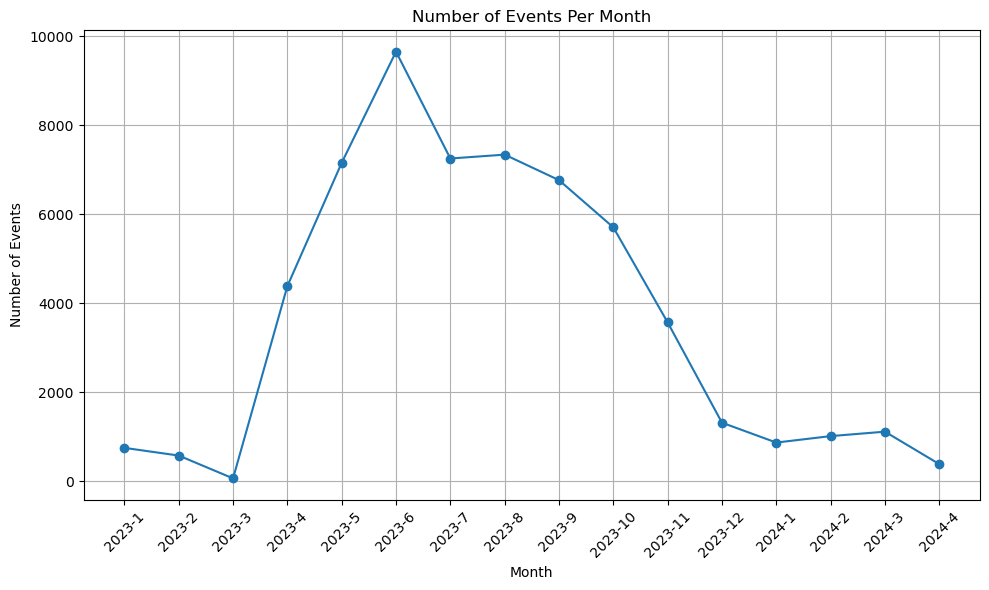

In [36]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_events['year_month'], monthly_events['event_count'], marker='o')

# Formatting the graph
plt.xticks(rotation=45)
plt.title('Number of Events Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Calculate the number of events daily

In [37]:
# Aggregate the number of events daily
daily_event_count_df = events_df.groupby('event_date').size().reset_index(name='total_event_count')

# Display the result
daily_event_count_df.head()

,event_date,total_event_count
0,2023-01-01,222
1,2023-01-02,127
2,2023-01-03,128
3,2023-01-04,125
4,2023-01-05,129


In [38]:
daily_event_count_df.to_csv("../data/curated/events/daily_event_count.csv", index=False)